# Differentiable Simulation of Detailed Neuron Morphologies
Author: Christian Pehle


In [3]:
import jax.numpy as np
import tree_math
import dataclasses

from jaxsnn.base import funcutils
from jaxsnn.base import implicit
from jaxsnn.base.tree_solver import tree_solve, tree_matmul
from jaxsnn.base.types import ArrayLike

import jaxsnn.morph.generate_morphologies as gm
import matplotlib.pyplot as plt

In [4]:
@tree_math.struct
class HodgekinHuxleyState:
    v: ArrayLike
    m: ArrayLike
    h: ArrayLike
    n: ArrayLike

@tree_math.struct
class HodgekinHuxleyChannelState:
    m: ArrayLike
    h: ArrayLike
    n: ArrayLike


@tree_math.struct
class HodgekinHuxleyParameters:
    g_K: ArrayLike
    E_K: ArrayLike
    g_Na: ArrayLike
    E_Na: ArrayLike
    g_L: ArrayLike
    E_L: ArrayLike
    C_m_inv: ArrayLike

In [5]:
def channel_dynamics(alpha, beta):
    def dynamics(x: ArrayLike, v: ArrayLike):
        return alpha(v) * (1 - x) - beta(v) * x

    return dynamics

In [6]:
def alpha_n(Vm):
    return (0.02 * (Vm - 25.0)) / (1.0 - np.exp((-1.0 * (Vm - 25.0)) / 9.0))


def beta_n(Vm):
    return (-0.002 * (Vm - 25.0)) / (1.0 - np.exp((Vm - 25.0) / 9.0))


def alpha_m(Vm):
    return (0.182 * (Vm + 35.0)) / (1.0 - np.exp((-1.0 * (Vm + 35.0)) / 9.0))


def beta_m(Vm):
    return (-0.124 * (Vm + 35.0)) / (1.0 - np.exp((Vm + 35.0) / 9.0))


def alpha_h(Vm):
    return 0.25 * np.exp((-1.0 * (Vm + 90.0)) / 12.0)


def beta_h(Vm):
    return (0.25 * np.exp((Vm + 62.0) / 6.0)) / np.exp((Vm + 90.0) / 12.0)

In [7]:
def x0(alpha, beta):
    def x0(v):
        return alpha(v) / (alpha(v) + beta(v))

    return x0


h0 = x0(alpha_h, beta_h)
n0 = x0(alpha_n, beta_n)
m0 = x0(alpha_m, beta_m)

In [8]:
def I_Na(s: HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_Na * np.power(s.m, 3) * s.h * (s.v - p.E_Na)


def I_K(s: HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_K * np.power(s.n, 4) * (s.v - p.E_K)


def I_L(s: HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_L * (s.v - p.E_L)


def hodgekin_huxley_dynamics(p: HodgekinHuxleyParameters):
    m_dynamics = channel_dynamics(alpha_m, beta_m)
    h_dynamics = channel_dynamics(alpha_h, beta_h)
    n_dynamics = channel_dynamics(alpha_n, beta_n)

    def dynamics(s: HodgekinHuxleyState, I: ArrayLike):
        return HodgekinHuxleyState(
            v=-p.C_m_inv * (I_K(s, p) + I_Na(s, p) + I_L(s, p) - I),
            m=m_dynamics(s.m, s.v),
            n=n_dynamics(s.n, s.v),
            h=h_dynamics(s.h, s.v),
        )

    return dynamics

def hodgekin_huxley_channel_dynamics(p: HodgekinHuxleyParameters):
    m_dynamics = channel_dynamics(alpha_m, beta_m)
    h_dynamics = channel_dynamics(alpha_h, beta_h)
    n_dynamics = channel_dynamics(alpha_n, beta_n)

    def dynamics(s: HodgekinHuxleyChannelState, v: ArrayLike):
        return HodgekinHuxleyChannelState(
            m=m_dynamics(s.m, v),
            n=n_dynamics(s.n, v),
            h=h_dynamics(s.h, v),
        )

    return dynamics

def hodgekin_huxley_current(s: HodgekinHuxleyState, p : HodgekinHuxleyParameters):
    return I_K(s, p) + I_Na(s, p) + I_L(s, p)

In [62]:
def hodgekin_huxley_initial_state(v: ArrayLike):
    h0 = x0(alpha_h, beta_h)
    n0 = x0(alpha_n, beta_n)
    m0 = x0(alpha_m, beta_m)
    return HodgekinHuxleyState(v=v, m=m0(v), h=h0(v), n=n0(v))

In [45]:
@tree_math.struct
class NeuronState:
    v: ArrayLike
    I: ArrayLike
    c: HodgekinHuxleyChannelState



@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
    d: ArrayLike
    u: ArrayLike
    p: ArrayLike
    h: HodgekinHuxleyParameters



    def explicit_terms(self, state):
        return NeuronState(
            v=state.I - hodgekin_huxley_current(HodgekinHuxleyState(v=state.v, m=state.c.m, n=state.c.n, h=state.c.h), self.h), 
            I=-20 * state.I, 
            c=hodgekin_huxley_channel_dynamics(self.h)(state.c, state.v)
        )

    def implicit_terms(self, state):
        return NeuronState(
            v=tree_matmul(self.d, self.u, self.p, state.v), 
            I=np.zeros_like(state.I),
            c=HodgekinHuxleyChannelState(m=np.zeros_like(state.I), n=np.zeros_like(state.I), h=np.zeros_like(state.I))
        )

    def implicit_solve(self, state, step_size):
        return NeuronState(
            v=tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
            I=state.I,
            c=state.c
        )

We are using arbor for loading .swc geometries

In [46]:
import arbor

morph = arbor.load_swc_arbor(
    "../../data/morphologies/allen/Cux2-CreERT2_Ai14-211772.05.02.01_674408996_m.swc"
)
policy = arbor.cv_policy_every_segment()
# generate control volumes
decor = arbor.decor()
decor = decor.discretization(policy)
# define regions using standard SWC tags
labels = arbor.label_dict(
    {"soma": "(tag 1)", "axon": "(tag 2)", "dend": "(join (tag 3) (tag 4))"}
)
cell = arbor.cable_cell(morph, decor, labels)
cv_data = arbor.cv_data(cell)
ncv = cv_data.num_cv

In [47]:
import numpy as onp

morph = gm.swc_geometry(
    "../../data/morphologies/allen/Cux2-CreERT2_Ai14-211772.05.02.01_674408996_m.swc"
)
tm = gm.compute_tree_matrix(morph)


N = len(tm.d)
dt = 0.01
inner_steps = 10
outer_steps = 20000
time = dt * inner_steps * (1 + np.arange(outer_steps))

param = HodgekinHuxleyParameters(
    C_m_inv=1.0,  # Inverse Membrane capacitance per unit area (cm^2/uF)
    g_K=35.0,  # Average potassium channel conductance per unit area (mS/cm^2)
    g_Na=40.0,  # Average sodoum channel conductance per unit area (mS/cm^2)
    g_L=0.3,  # Average leak channel conductance per unit area (mS/cm^2)
    E_K=-77.0,  # Potassium potential (mV)
    E_Na=55.0,  # Sodium potential (mV)
    E_L=-65.0,  # Leak potential (mV)
)

equation = MultiCompartmentNeuronModel(d=tm.d, u=tm.u, p=tm.p, h=param)

semi_implicit_step = implicit.imex_rk_sil3(equation, dt)
integrator = funcutils.trajectory(
    funcutils.repeated(semi_implicit_step, inner_steps), outer_steps
)

initial_state = NeuronState(v=param.E_L*np.ones(N), I=np.zeros(N), c=HodgekinHuxleyChannelState(m=m0(param.E_L)*np.ones(N), n=n0(param.E_L)*np.ones(N), h=h0(param.E_L)*np.ones(N)))
_, actual = integrator(initial_state)

In [50]:
np.min(actual.v), np.max(actual.v), np.max(actual.v[-1]), np.min(actual.v[-1])


norm = np.max(actual.v) - np.min(actual.v)
min_v = np.min(actual.v)
norm

Array(nan, dtype=float32)

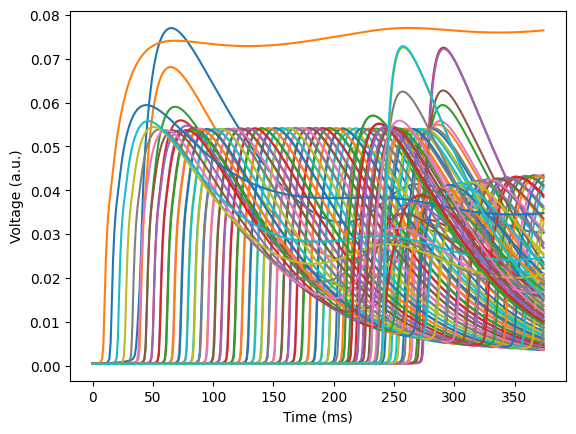

In [61]:
i = 70
plt.plot(actual.c.n[:600,:100])
plt.ylabel("Voltage (a.u.)")
plt.xlabel("Time (ms)")
plt.savefig("example_trace_v.png", dpi=300)

In [14]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm


def plot_morphology(ax, morph, colors=None, colorscheme='Blues'):
    nb = morph.num_branches

    min_x = 0
    max_x = 1
    min_y = 0
    max_y = 1

    lines = []
    idx = 0
    cm = matplotlib.colormaps[colorscheme]

    indices = []

    for i in range(nb):
        segs = morph.branch_segments(i)
        xs = []
        ys = []

        for seg in segs:
            if colors is None:
                color = 'black'
            else:
                color = cm(colors[idx])
            xs.append(seg.prox.x)
            xs.append(seg.dist.x)
            ys.append(seg.prox.y)
            ys.append(seg.dist.y)
            idx = idx + 1


            lines.append(Line2D([seg.prox.x, seg.dist.x], [seg.prox.y, seg.dist.y], linewidth=1, color=color))

        min_x = min(min_x, min(xs))
        max_x = max(max_x, max(xs))
        min_y = min(min_y, min(ys))
        max_y = max(max_y, max(ys))

    for line in lines:
        ax.add_line(line)

    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

In [15]:
actual.v.shape

(2048, 7430)

In [19]:
import matplotlib as mpl
import matplotlib.animation as animation


def animate_dynamics(actual, morph, filename, n_frames=300, colorscheme='Blues'):
    fig, ax = plt.subplots(figsize=(10, 10))
    step = 0

    v = (actual.v[10*step] - min_v)/norm 
    ax.set_axis_off()
    plot_morphology(ax, morph, colors=onp.array(v))
    fig.tight_layout()

    def update(step):
        ax.clear()
        ax.set_axis_off()
        v = (actual.v[10*step] - min_v)/norm 
        plot_morphology(ax, morph, colors=onp.array(v), colorscheme=colorscheme)
        fig.tight_layout()
        return ax

    ani = animation.FuncAnimation(
        fig, update, frames=np.arange(0, n_frames, 1), interval=100
    )
    ani.save(filename, writer="ffmpeg", fps=60)

[0.0000000e+00 1.3458950e-04 2.6917900e-04 ... 9.9959624e-01 9.9973083e-01
 9.9986541e-01]


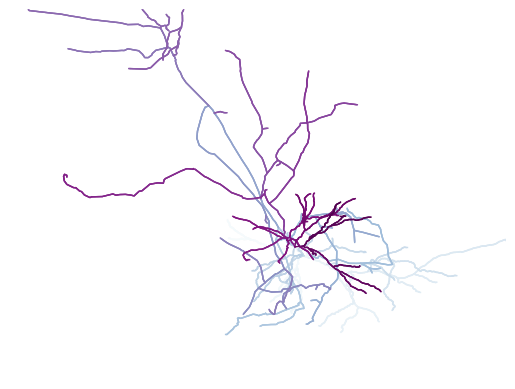

In [20]:
ax = plt.gca()
ax.set_axis_off()

colors = np.arange(0,actual.v.shape[1])/actual.v.shape[1]
print(colors)
plot_morphology(ax, morph, colors=colors, colorscheme='BuPu')
plt.savefig("example_morphology.png", dpi=300)

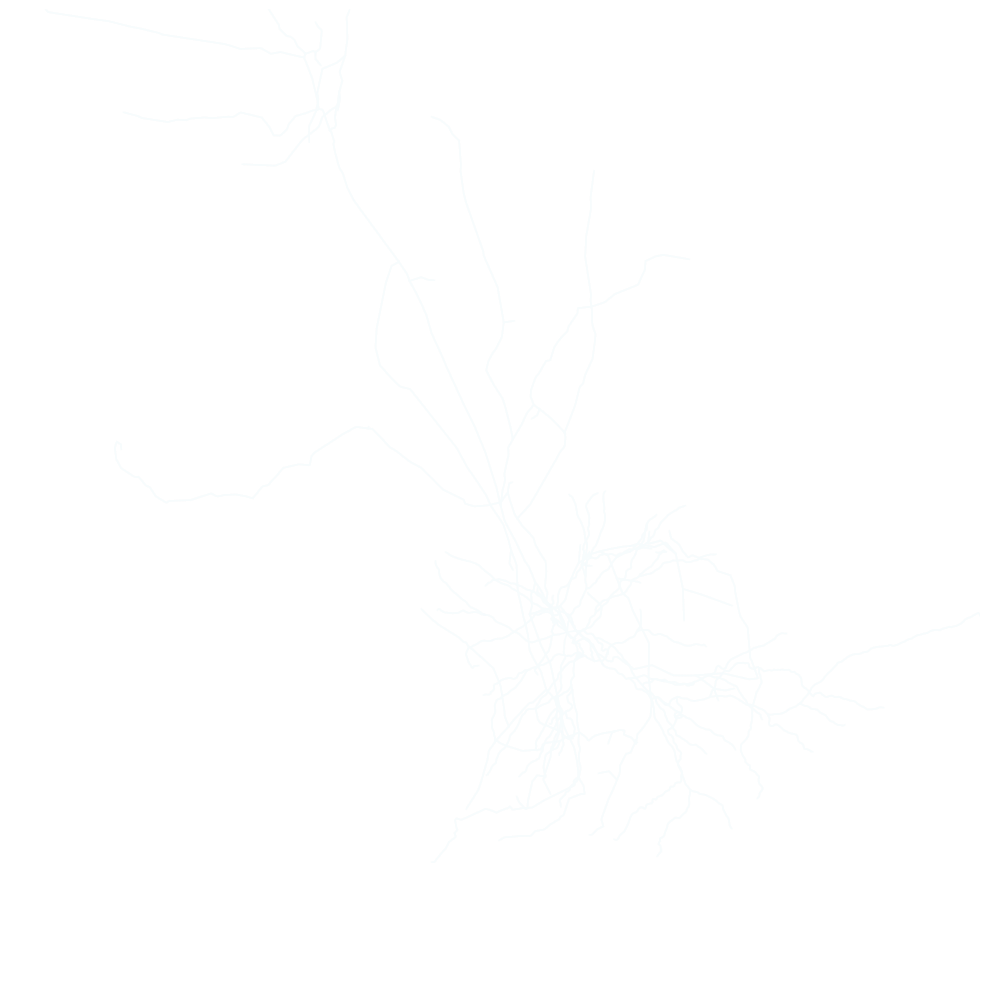

In [21]:
animate_dynamics(actual, morph, filename="test.mp4", n_frames=actual.v.shape[0]//10, colorscheme='BuPu')